In [4]:
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import seaborn as sns

# Function to draw pitch saved in another file called support_functions.py
from support_functions import pitch, draw_pitch

# Load data

In [5]:
df = pd.read_json('data/figshare/match/matches_England.json')
df_events = pd.read_json('data/figshare/events/events_England.json')
df_teams = pd.read_json('data/figshare/teams.json')
df_players = pd.read_json('data/figshare/players.json')
df_player_rank = pd.read_json('data/figshare/playerank.json')
df_tags = pd.read_csv('data/figshare/tags2name.csv')

# Data Prep

In [6]:
# Split out the position data into separate columns 
df_events.dropna(subset=['positions'], inplace=True)
for char in "{[yx:']} ":
    df_events['positions'] = df_events['positions'].astype(str).str.replace(char, '') 
    
df_events['positions'] = df_events['positions'].str.split(',')
pos = pd.DataFrame(df_events["positions"].to_list(), columns=['y', 'x','y2','x2'])
df_events = df_events.merge(pos , how= 'left', left_index=True, right_index = True)

df_events.dropna(subset=['y', 'x','y2','x2'], inplace=True)
df_events.reset_index(inplace=True)
# Create the change in x and change in y columns
df_events['dx'] = df_events['x2'].astype(int) - df_events['x'].astype(int)
df_events['dy'] = df_events['y2'].astype(int) - df_events['y'].astype(int)

In [7]:
# Expand the nested json data for players here
df_players = pd.concat([df_players, json_normalize(df_players['role'])], axis=1, sort=False)
df_players = df_players[['shortName','code3','wyId','birthDate','height','weight','foot']]

# Pull out the event tag ids into separate columns
df_events = df_events.join(pd.DataFrame(df_events.tags.values.tolist()))

# Rename the tag id columns. Each event has a variable number of tags depending what it is. 
df_events.rename(columns = {0:'tag_1',1:'tag_2',2:'tag_3',3:'tag_4',4:'tag_5',5:'tag_6'}, inplace=True)

# Create a dictionary of the tag to tag descriptions
area_dict = dict(zip(df_tags.Tag, df_tags.Description))

# For each tag convert from id to description
for col in ['tag_1','tag_2','tag_3','tag_4','tag_5']:
    df_events[col] = df_events[col].astype(str)
    df_events[col] = df_events[col].str.replace("{'id': ","").str.replace("}","")
    df_events[col] = df_events[col].replace('None', 'NaN').astype(float)
    df_events[col] = df_events[col].map(area_dict)
    df_events[col] = df_events[col].astype(str) 
    
# Create a column that concatenates the tag descriptions
df_events['tag_descriptions'] = df_events[['tag_1','tag_2','tag_3','tag_4','tag_5']].agg(','.join, axis=1)

# Add the players shortname to the events as that's pretty useful most of the time. 
df_events = df_events.merge(df_players, how='left', left_on='playerId', right_on='wyId')

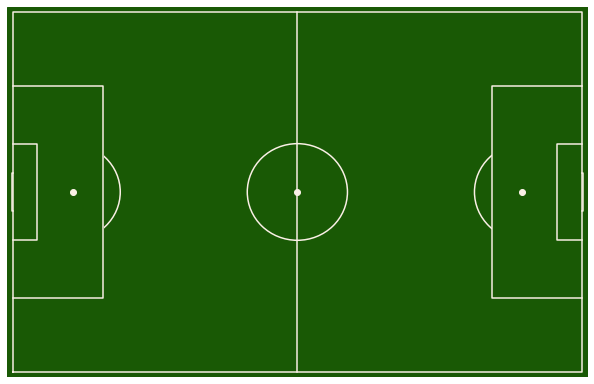

In [8]:
f = draw_pitch("#195905", "#faf0e6", "h", "full")

(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12cad83f390>)

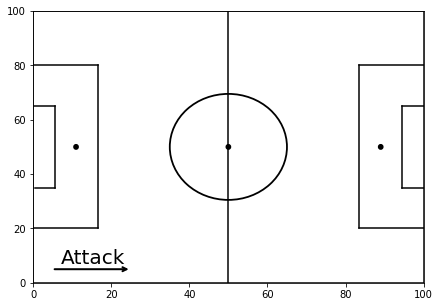

In [9]:
pitch()

# Support Functions

In [129]:
def bar_graph(df, bar_1, bar_2, y_axis_label, label1, label2, filename = 'draft'):
    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars1 = df[bar_1].values
    bars2 = df[bar_2].values

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label=label1)
    plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label=label2)

    # Add xticks on the middle of the group bars
    plt.xlabel('Player', fontweight='bold')
    plt.ylabel(y_axis_label, fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], df['shortName'].values, rotation=90)

    # Create legend & Show graphic
    plt.legend()
    plt.tight_layout()
    plt.savefig('pass_results/{}.png'.format(filename))
    plt.show()


# Explore One Season 

- For defenders and midfields who is the most effective at moving the ball through the pitch. 
    - Forward distance gained on average
    - % of passes that are forward (do they look to play forward)
    - pass completion
    

In [130]:
# Note the net - as passes going backwards are also included.

df_forward_gain = df_events[(df_events['eventName'] =='Pass')].groupby('playerId', as_index=False).agg({'dx':'sum',
                                                                    'matchId':'count'}).sort_values('dx',
                                                                                                    ascending=False)
df_forward_gain.rename(columns={'matchId':'number_events',
                               'dx':'net_perc_x_gain'}, inplace=True)

# Now only take the passes that are accurate and look at average forward distance made of accurate passes. 
df_forward_gain_just_accurate = df_events[(df_events['eventName'] =='Pass') & (df_events['tag_descriptions']\
                                                                               .str.contains('Accurate'))]\
                                                                               .groupby('playerId', as_index=False)\
                                                                               .agg({'dx':'sum','matchId':'count'})\
                                                                               .sort_values('dx', ascending=False)

df_forward_gain_just_accurate.rename(columns={'matchId':'number_events_accurate',
                               'dx':'net_perc_x_gain_accurate'}, inplace=True)


# Join the forward pass information for accurate and not accurate passes
df_forward_gain= df_forward_gain.merge(df_forward_gain_just_accurate, how='left', left_on='playerId', right_on='playerId')

# Number of accurate passes
df_pass_accurate = df_events[(df_events['eventName'] =='Pass') &
                            (df_events['tag_descriptions'].str.contains('Accurate'))].groupby('playerId', as_index=False).agg({'matchId':'count'})

df_pass_accurate.rename(columns={'matchId':'accurate_passes'}, inplace=True)

# Join with the player data to get their names
df_forward_gain= df_forward_gain.merge(df_players, how='left', left_on='playerId', right_on='wyId')
# Join the accurate pass data
df_forward_gain= df_forward_gain.merge(df_pass_accurate, how='left', left_on='playerId', right_on='playerId')

# Calculate the average percent gain per pass.
df_forward_gain['average_net_x_perc_gain_per_pass'] = df_forward_gain['net_perc_x_gain'] / df_forward_gain['number_events']
df_forward_gain['average_net_x_perc_gain_per_pass_accurate'] = df_forward_gain['net_perc_x_gain_accurate'] / df_forward_gain['number_events_accurate']
# Calculate the pass accuracy
df_forward_gain['pass_accuracy_perc'] = df_forward_gain['accurate_passes']/df_forward_gain['number_events']


In [131]:
# Midfielders
# Only include those with more than 500 passes over the season. 
midf_top = df_forward_gain[(df_forward_gain['code3'] == 'MID') &
                (df_forward_gain['number_events'] > 500)
               ].sort_values('average_net_x_perc_gain_per_pass_accurate',
                             ascending=False)[['shortName',
                                               'number_events',
                                               'average_net_x_perc_gain_per_pass',
                                               'average_net_x_perc_gain_per_pass_accurate',
                                               'pass_accuracy_perc']].head(10)

midf_bottom = df_forward_gain[(df_forward_gain['code3'] == 'MID') &
                (df_forward_gain['number_events'] > 500)
               ].sort_values('average_net_x_perc_gain_per_pass_accurate',
                             ascending=False)[['shortName',
                                               'number_events',
                                               'average_net_x_perc_gain_per_pass',
                                               'average_net_x_perc_gain_per_pass_accurate',
                                               'pass_accuracy_perc']].tail(10)


In [132]:
# Defenders
# Only include those with more than 500 passes over the season. 
defd = df_forward_gain[(df_forward_gain['code3'] == 'DEF') &
                (df_forward_gain['number_events'] > 500)
               ].sort_values('average_net_x_perc_gain_per_pass_accurate',
                             ascending=False)[['shortName',
                                               'number_events',
                                               'average_net_x_perc_gain_per_pass',
                                               'average_net_x_perc_gain_per_pass_accurate',
                                               'pass_accuracy_perc']].head(10)

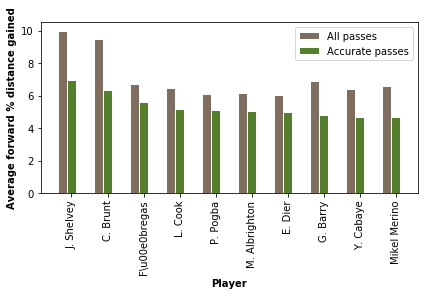

In [133]:
bar_graph(midf_top, bar_1 = 'average_net_x_perc_gain_per_pass', bar_2 ='average_net_x_perc_gain_per_pass_accurate',
          y_axis_label='Average forward % distance gained', label1='All passes', label2='Accurate passes',
         filename = 'Forward_progress_top_10_mid.png')

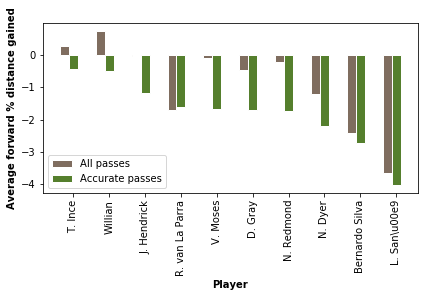

In [134]:
bar_graph(midf_bottom, bar_1 = 'average_net_x_perc_gain_per_pass', bar_2 ='average_net_x_perc_gain_per_pass_accurate',
          y_axis_label='Average forward % distance gained', label1='All passes', label2='Accurate passes',
         filename = 'Forward_progress_bottom_10_mid.png')

Remember these are all in %, but as a football pitch is about 100m long , thinking in metres as well isn't so bad. 

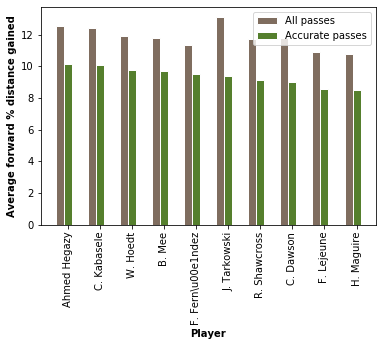

In [15]:
bar_graph(defd, bar_1 = 'average_net_x_perc_gain_per_pass', bar_2 ='average_net_x_perc_gain_per_pass_accurate',
          y_axis_label='Average forward % distance gained',  label1='All passes', label2='Accurate passes')

Interestingly Shelvey is the highest rated midfield player. Shelveys unsuccessful passes are evidently more ambitious in terms of forward ground and may explain why they're not successful. 

Distance per pass is important but so is pass accuracy. Where's the best balance between taking risks to get further up the field but keeping the ball.

When you just look at distance made from accurate passes - Shelvey still comes out on top.

These players are the ones making you the most forward distance, which makes them useful players. 

In [16]:
# Further ideas 
# Forward ground made per pass but scaling for the position on the pitch. (Convert x into a log scale)
# what about ignoring backwards passes

# Explore One Match 

- Liverpool v Brighton
- May 13th 2018

In [17]:
def draw_arrows(row, axis=plt):
    axis.arrow(int(row['x']),int(row['y']), int(row['dx']), int(row['dy']),width=0.5)
    return

In [119]:
class Match():
    
    '''
    A class to store a single match. 
    Intention is to make it a little easier to navigate analysing one match.
    
    inputs
    - the match id in question
    - all original datasets
    - extracts only the data relating to this specific match. 
    '''
    
    def __init__(self, match_id, df_matches, df_events, df_teams,df_players, df_player_rank):
        self.match_id = match_id
        self.match = df_matches[df_matches['wyId'] == match_id].reset_index()
        self.events = df_events[df_events['matchId'] == match_id].reset_index()
        self.player_rank = df_player_rank[df_player_rank['matchId'] == match_id].reset_index()
        print('Number of events in this match is {}'.format(len(self.events)))
        
        # Easiest to use the label (names of teams) to get home and away team
        self.home_team = self.match['label'][0].split(',')[0].split(' - ')[0] 
        self.away_team = self.match['label'][0].split(',')[0].split(' - ')[1] 
        
        self.homeid = df_teams[df_teams['name'] ==self.home_team]['wyId'].reset_index()['wyId'][0]
        self.awayid = df_teams[df_teams['name'] ==self.away_team]['wyId'].reset_index()['wyId'][0]
        
        self.team_data = json_normalize(self.match['teamsData'][0])
        
        # Create lineups for each team
        self.home_lineup = json_normalize(self.team_data[str(self.homeid) + '.formation.lineup'][0])
        self.away_lineup = json_normalize(self.team_data[str(self.awayid) + '.formation.lineup'][0])
        
        # Join with the player data so we have their names and characteristics.
        self.home_lineup = self.home_lineup .merge(df_players, how='left', left_on='playerId', right_on='wyId')
        self.away_lineup = self.away_lineup.merge(df_players, how='left', left_on='playerId', right_on='wyId')
        
        # Join with the player rank data so we have their exact position and their rank
        self.home_lineup = self.home_lineup.merge(self.player_rank, how='left', left_on='playerId', right_on='playerId')
        self.away_lineup = self.away_lineup.merge(self.player_rank, how='left', left_on='playerId', right_on='playerId')
        
        # Calculate the net % distance made up the pitch
        grouped_forward_distance = self.events.groupby('playerId', as_index=False).agg({'dx':'sum'})
        self.home_lineup = self.home_lineup.merge(grouped_forward_distance, how='left', left_on ='playerId', right_on='playerId')
        self.away_lineup = self.away_lineup.merge(grouped_forward_distance, how='left', left_on ='playerId', right_on='playerId')
    
    def arrow_pass_map_player(self, playerId):
        pitch()
        self.events[(self.events['playerId'] == playerId) & (self.events['eventName'] == 'Pass') ].apply(draw_arrows, axis=1)
        plt.show()
        
    def keeper_distribution_location(self, playerId, player_name):
        pitch()
        self.player_passes = self.events[(self.events['playerId'] == playerId) & (self.events['eventName'] == 'Pass') ]
        sns.kdeplot(self.player_passes['x2'],self.player_passes['y2'], cmap = 'Blues', shade = True)
        plt.savefig('pass_results/keeper_dist_{}.png'.format(player_name))
        plt.show()
        
    def net_positive_ground(self):
        # Compare the net positive ground made (passes only)
        plt.bar(self.home_lineup['shortName'], self.home_lineup['dx'])
        plt.xticks(rotation=90)
        plt.xlabel('player')
        plt.ylabel('net % pitch gain')
        plt.tight_layout()
        plt.savefig('pass_results/home_team_positive.png')
        plt.show()
        
        # away team
        plt.bar(self.away_lineup['shortName'], self.away_lineup['dx'])
        plt.xticks(rotation=90)
        plt.xlabel('player')
        plt.ylabel('net % pitch gain')
        plt.tight_layout()
        plt.savefig('pass_results/away_team_positive.png')
        plt.show()

    def display_keeper_distribution(self):
        # Compare the tactics of the two keepers
        keepers = []
        keepers_names = []
        keepers.append(self.home_lineup[self.home_lineup['code3'] == 'GKP'].reset_index()['playerId'][0])
        keepers.append(self.away_lineup[self.away_lineup['code3'] == 'GKP'].reset_index()['playerId'][0])
        self.arrow_pass_map_player(keepers[0])
        self.arrow_pass_map_player(keepers[1])
        plt.show()
        

     

In [120]:
example_game = Match(2500092, df, df_events, df_teams, df_players,df_player_rank)

Number of events in this match is 1703


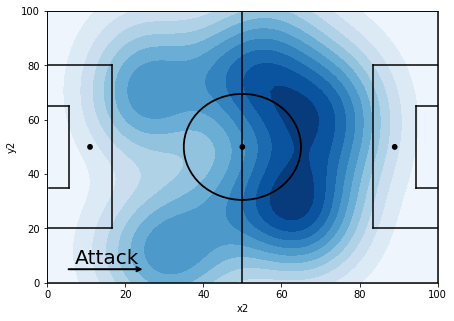

In [122]:
example_game.keeper_distribution_location(61390, 'M. Ryan')

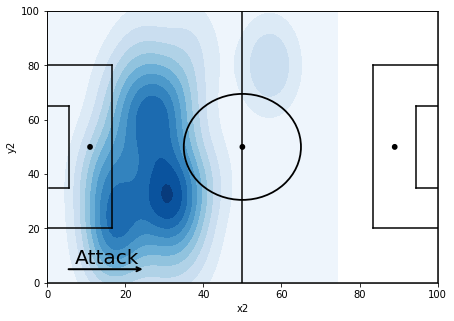

In [123]:
example_game.keeper_distribution_location(15175, 'L. Karius')

In [124]:
#example_game.away_lineup

In [125]:
#example_game.home_lineup

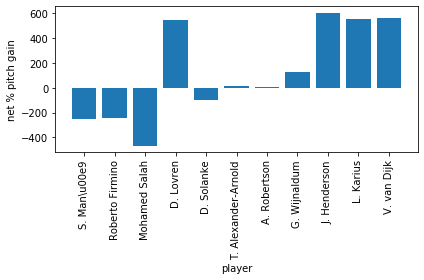

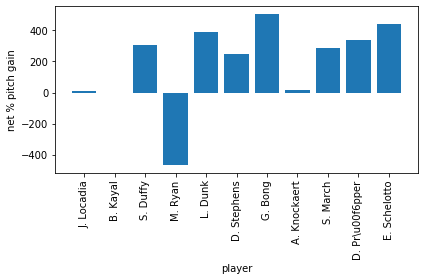

In [111]:
example_game.net_positive_ground()

In [126]:
#example_game.display_keeper_distribution()

In [24]:
# Who won the league that year. Look at what games they lost and how. 
# Or look at where they conceded goals and how are there any patterns 
# What else could we look at. 

https://www.nytimes.com/2019/05/22/magazine/soccer-data-liverpool.html

He has only slightly less contempt for some of the more evolved metrics, like the percentage of attempted passes that are completed. Instead, he spent months building a model that calculates the chance each team had of scoring a goal before any given action — a pass, a missed shot, a slide tackle — and then what chance it had immediately after that action. Using his model, he can quantify how much each player affected his team’s chance of winning during the game. Inevitably, some of the players who come out best in the familiar statistics end up at the top of Graham’s list.

### Interesting so attribute every single event to making a goal. Then you can see how much each event contributes. 

### Really interesting approach to valueing every action in the game
https://twelve.football/analytics



# Assists and Value of passes

How to find out the true value of every pass. 
(This makes me think Markov chain and assign transition probabilities to an action resulting in a goal.)

But maybe make a really simple first pass: 

- Take every passage of possession

- Does it lead to a goal or not

- Discount the contribution by how far away from the goal each pass was in terms of passes (this is pretty weak but simple)

- Use this to model for a certain pass [x,y, dx,dy] how likely is it to lead to a goal. 

- You then sum up all these passes for every player and see who comes out on top. How different is it to forward distance made. 

Most passes are going to be zero - don't lead to a goal - this might be an issue with this approach - football sparse goals.

In [45]:
# Basic Assists Metric - baseline comparison
# include only where defined as assist by tag_1
assists = df_events[df_events['tag_1'].str.contains('Assist')]
# Count number of assists per player
assists = assists.groupby('playerId', as_index =False).agg({'eventName':'count'}).sort_values('eventName', ascending=False)
assists.rename(columns={'eventName':'number_of_actions'}, inplace=True)
# Add in the player information
assists = assists.merge(df_players, how='left', left_on='playerId', right_on='wyId')
# Assign each assist the value of 0.8. (idea being that a goal would get 1)
assists['value_of_assists'] = assists['number_of_actions'] * 0.8 
assists.head(50)

,playerId,number_of_actions,shortName,code3,wyId,birthDate,height,weight,foot,value_of_assists
0,38021,16,K. De Bruyne,MID,38021,1991-06-28,181,68,right,12.8
1,245364,13,L. San\u00e9,MID,245364,1996-01-11,184,76,left,10.4
2,8317,10,David Silva,MID,8317,1986-01-08,173,67,left,8.0
3,26150,10,R. Mahrez,MID,26150,1991-02-21,179,62,left,8.0
4,11066,10,R. Sterling,FWD,11066,1994-12-08,170,69,right,8.0
5,54,9,C. Eriksen,MID,54,1992-02-14,180,76,right,7.2
6,105338,9,H. Mkhitaryan,MID,105338,1989-01-21,177,75,right,7.2
7,13484,9,D. Alli,MID,13484,1996-04-11,188,80,right,7.2
8,120353,8,Mohamed Salah,FWD,120353,1992-06-15,175,72,left,6.4
9,15526,8,P. Gro\u00df,MID,15526,1991-06-15,181,78,right,6.4


In [26]:
# Find all of the goals in the event data
goals = df_events[(df_events['tag_1'].str.contains('Goal')) & (df_events['eventName'] == 'Shot')]

# Use these goals to find the 15 events that lead up to a goal.

df_all_value_contributions = pd.DataFrame()
# For each goal
for goal in goals.index:
    
    # Take only the events leading up to the goal
    # Add 1 to the goal if you want to include goals
    df_passage = df_events[goal-15:goal]
    
 
    # Which team scored
    team = df_events['teamId'][goal]
    # Keep only the events from the team that scored
    df_passage = df_passage[df_passage['teamId'] == team]
    # For now just keep what I think we need eventName, position_data, playerId
    df_passage = df_passage[['eventName', 'x','y','x2','y2','playerId','shortName']]
    # Assign a value to each event leading up to a goal. Super simple for now. 0.8^(how far back in the passage it was)
    df_passage['value_of_action'] = 0.8**(goal - df_passage.index) 

    # append each passage 
    df_all_value_contributions = df_all_value_contributions.append(df_passage)

# Group at the player level.
player_contribution = df_all_value_contributions.groupby('playerId', as_index=False)\
                                                .agg({'value_of_action' : 'sum', 
                                                      'eventName':'count',
                                                     'shortName':'min'})\
                                                .sort_values('value_of_action', ascending=False)

player_contribution.rename(columns={'eventName':'number_of_actions'}, inplace=True)

In [27]:
player_contribution.head(10)

,playerId,value_of_action,number_of_actions,shortName
0,0,117.364361,438,NaN
298,38021,40.994347,116,K. De Bruyne
361,120353,33.561376,81,Mohamed Salah
220,11066,28.997105,90,R. Sterling
132,8317,27.566470,87,David Silva
391,245364,27.361020,71,L. San\u00e9
25,3319,25.812889,92,M. \u00d6zil
68,7905,25.637845,61,R. Lukaku
286,26150,24.067909,59,R. Mahrez
4,54,23.561528,82,C. Eriksen


# Assists compared to Passes leading to goal
Look at someone like Firminio. 40th on Assists list but 13th on value of passes list. Quite a big jump. 
Value of passes work assigns a assist 0.8 and each pass before progressively less. 
If we just looked at assists and assigned these 0.8 how big would the difference be for certain players.

In [28]:
# compare assists to value of passes leading to a goal
compare_df = player_contribution.merge(assists[['value_of_assists','playerId']], how='left', left_on='playerId', right_on='playerId')
compare_df[['value_of_action', 'number_of_actions' , 'value_of_assists','shortName']]
compare_df['diff'] =  compare_df['value_of_action'] - compare_df['value_of_assists']
compare_df = compare_df[['diff','value_of_action','value_of_assists','shortName']].sort_values('diff', ascending=False)

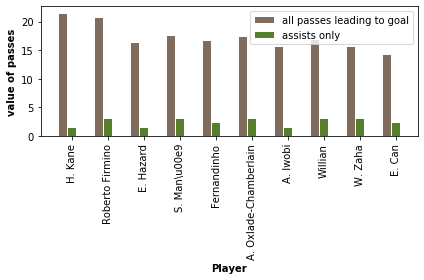

In [135]:
# Players with less than 4 formal assists. Ordered by the biggest difference
# between the assists and value of all passes that led to goal. 
value_but_low_assists = compare_df[compare_df['value_of_assists'] < 4].head(10)
bar_graph(value_but_low_assists, bar_1 = 'value_of_action', bar_2 ='value_of_assists',  y_axis_label='value of passes', label1='all passes leading to goal', label2='assists only',
          filename = 'low_assisters_with_high_value.png')

Here we start to see players who's actions are more valuable than assists might make you think. 

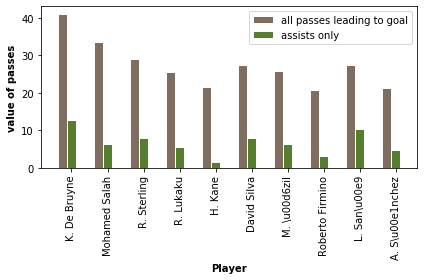

In [136]:
top_10_value = compare_df.head(10)
bar_graph(top_10_value, bar_1 = 'value_of_action', bar_2 ='value_of_assists',  y_axis_label='value of passes',
          label1='all passes leading to goal', label2='assists only',
          filename = 'High_value_passes.png')

A number of the players with high assists are also high on the all passes metric. De Bruyne whilst having the most assists is still the most valuable in the new metric.

More interesting ones are Kane and Firmino, who don't have many direct assists but have a lot of value in passes during passages of play leading to goals. 

# Analysing the location of a players valuable passes

In [32]:
df_all_value_contributions['dx'] = df_all_value_contributions['x2'].astype(int) - df_all_value_contributions['x'].astype(int)
df_all_value_contributions['dy'] = df_all_value_contributions['y2'].astype(int) - df_all_value_contributions['y'].astype(int)

In [137]:
class player():
    
    def __init__(self, df_key_passes, player, df_events):

        # df_passes is just the passes assigned value in the lead up to a goal
        self.df_key_passes = df_key_passes[(df_key_passes['playerId'] == player) & (df_key_passes['eventName'] == 'Pass')]

        self.player_name =  self.df_key_passes['shortName'].max().replace(' ','_')
        
        # df_position includes position of all passes
        self.df_position = df_events[(df_events['eventName'] == 'Pass') & (df_events['playerId'] == player)][['playerId','x','y','x2','y2','dx','dy']]
    
    # Plot arrows of the valuable passes
    def plot_arrows(self):
        pitch()
        self.df_key_passes.apply(draw_arrows, axis=1)
        plt.title('key passes')
        plt.savefig('pass_results/{}_arrows.png'.format(self.player_name))
        plt.show()
        
    def plot_all_passes_positions(self):
        pitch()
        sns.kdeplot(self.df_position['x'],self.df_position['y'], cmap = 'Blues', shade = True)
        plt.title('All pass positions')
        plt.savefig('pass_results/{}_all_pass.png'.format(self.player_name))
        plt.show()
        
    def plot_positions_valuable_passes(self):
        pitch()
        sns.kdeplot(self.df_key_passes['x'],self.df_key_passes['y'], cmap = 'Greens', shade = True)
        plt.title('Valuable pass positions')
        plt.savefig('pass_results/{}_value_pass.png'.format(self.player_name))
        plt.show()
              

In [ ]:
# Chose players of interest: I chose Firminio, Silva, Ali and Sterling

In [139]:
# firmi = player(df_all_value_contributions,15808 ,df_events)
# firmi.plot_arrows()
# firmi.plot_all_passes_positions()
# firmi.plot_positions_valuable_passes()

In [141]:
# ali = player(df_all_value_contributions,13484 ,df_events)
# ali.plot_arrows()
# ali.plot_all_passes_positions()
# ali.plot_positions_valuable_passes()

In [143]:
# silva = player(df_all_value_contributions,8317 ,df_events)
# silva.plot_arrows()
# silva.plot_all_passes_positions()
# silva.plot_positions_valuable_passes()

In [94]:
# sterling = player(df_all_value_contributions,11066 ,df_events)
# sterling.plot_arrows()
# sterling.plot_all_passes_positions()
# sterling.plot_positions_valuable_passes()

In [ ]:
 
# What we then want to do it build a model with the inputs being the pass location information. and the target being the value.
# ?? but can we then just apply this to all passes. Maybe because we're saying that's how valuable that pass can be. 
# You just didn't have very good finishers. Or do we need to do this process for all events that lead to a shot 
# we don't know how good the shot is. Maybe we need to all expected goals. 

# Because we want okay this was a great pass but then the 3 passes after it your team mates were useless but that pass was great
# Don't know if that quite makes sense. 
